# Data augmentation

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from IPython.display import clear_output

2025-01-04 15:28:53.925840: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-04 15:28:54.114478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736000934.196325    1108 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736000934.221536    1108 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 15:28:54.400248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Reading statistics

In [2]:
stats_file = "image_dimensions.csv"
#stats_file = "/kaggle/input/image-dimensions/image_dimensions.csv"
stats = pd.read_csv(stats_file)
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2801.000000,2801.000000
mean,602.956444,647.924313
std,415.799480,446.639298
min,106.000000,108.000000
25%,313.000000,383.000000
50%,546.000000,590.000000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,546.000000,590.000000


## Helper functions

In [3]:
width = int(stats.loc["median", "widths"])
height = int(stats.loc["median", "heights"])

def build_model(width, height, data_augmentation=None):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(width, height, 3)))

    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(64, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(128, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model = build_model(width, height)
model.summary()

I0000 00:00:1736000939.825663    1108 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 546, 590, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 544, 588, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 272, 294, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 270, 292, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 135, 146, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 133, 144, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 66, 72, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 70, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 35, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 33, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 253440)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       253,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,231,937 (4.70 MB)

 Trainable params: 1,231,937 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

In [5]:
def print_metrics(model, test):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")

In [6]:
def display_augmentation(data, data_augmentation):
    for images, _ in data.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

In [7]:
class DynamicMetricsPlotCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
       
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])
       
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
       
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
       
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
       
        plt.tight_layout()
        plt.show()

## Data augmentation

### Base model

In [8]:
painters = ["Mondriaan", "Picasso"]
dataset_dir = "undersampled_dataset"
#dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, width, height)

Found 312 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 104 files belonging to 2 classes.


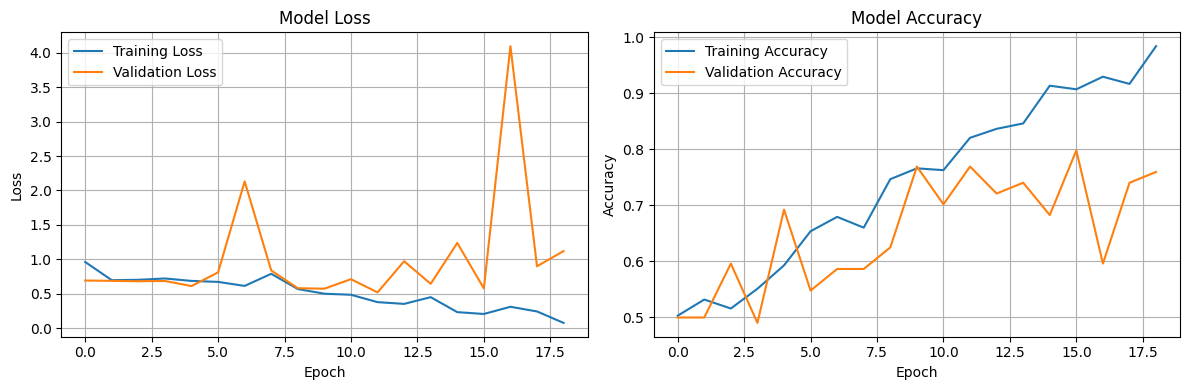

In [9]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [10]:
print_metrics(model, test)

Test Loss: 0.5025413036346436
Test Accuracy: 0.7307692170143127
Test Precision: 0.6666666865348816
Test Recall: 0.9230769276618958


### Randomflip

In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
])

2025-01-04 15:30:36.989181: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


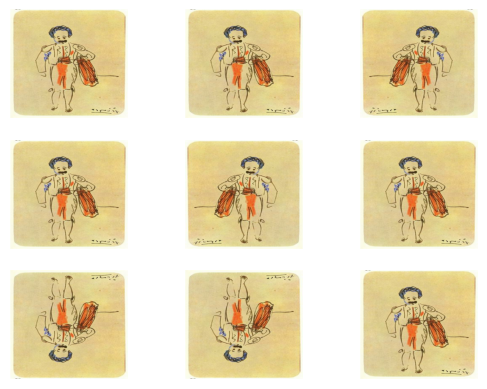

In [12]:
display_augmentation(train, data_augmentation)

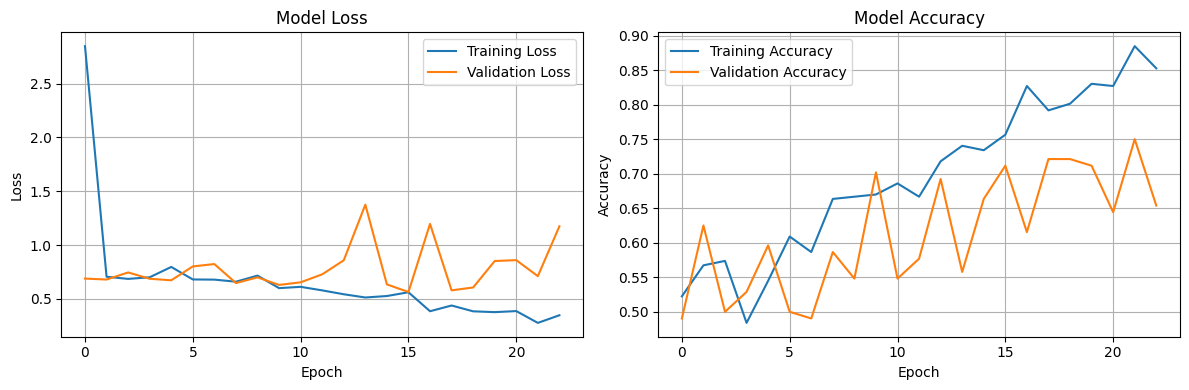

In [13]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [14]:
print_metrics(model, test)

2025-01-04 15:31:56.527496: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Test Loss: 0.5844144821166992
Test Accuracy: 0.7211538553237915
Test Precision: 0.7017543911933899
Test Recall: 0.7692307829856873


### RandomTranslation

In [15]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(0.3, 0.3),
])

2025-01-04 15:31:57.031476: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-01-04 15:31:57.031860: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-01-04 15:31:58.115990: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


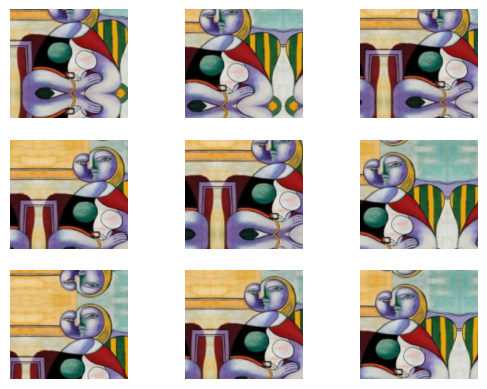

In [16]:
display_augmentation(train, data_augmentation)

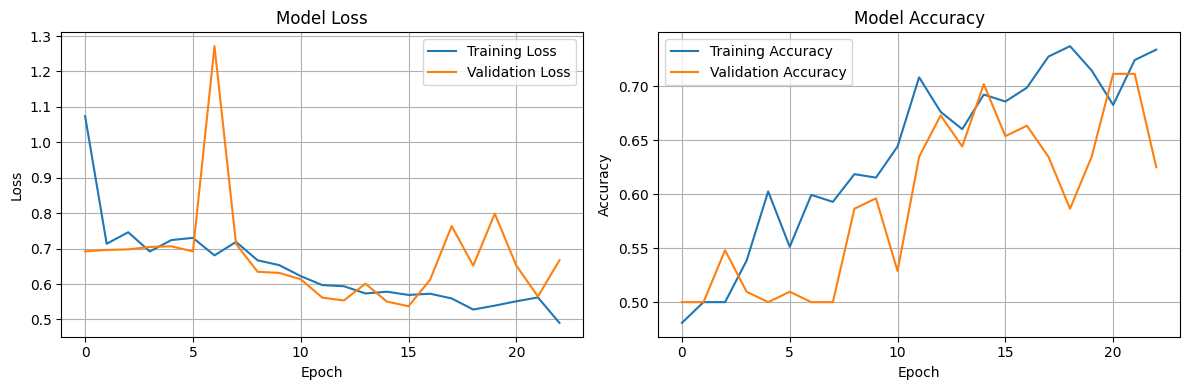

In [17]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [18]:
print_metrics(model, test)

2025-01-04 15:33:34.564434: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Test Loss: 0.5744364857673645
Test Accuracy: 0.692307710647583
Test Precision: 0.6470588445663452
Test Recall: 0.8461538553237915


### RandomZoom

In [19]:
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.3),
])

2025-01-04 15:33:36.233300: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-01-04 15:33:36.234994: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


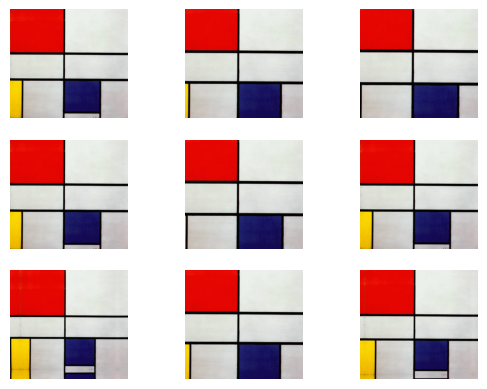

In [20]:
display_augmentation(train, data_augmentation)

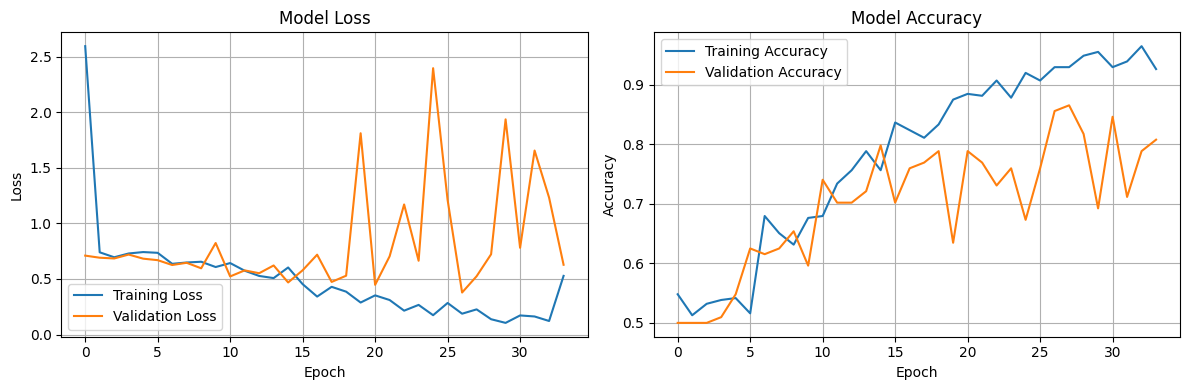

In [21]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [22]:
print_metrics(model, test)

2025-01-04 15:35:42.829754: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Test Loss: 0.5125309824943542
Test Accuracy: 0.8461538553237915
Test Precision: 0.8333333134651184
Test Recall: 0.8653846383094788


### RandomContrast

In [23]:
data_augmentation = keras.Sequential([
    layers.RandomContrast(0.3),
])

2025-01-04 15:35:43.357517: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-01-04 15:35:43.358348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-01-04 15:35:45.747193: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


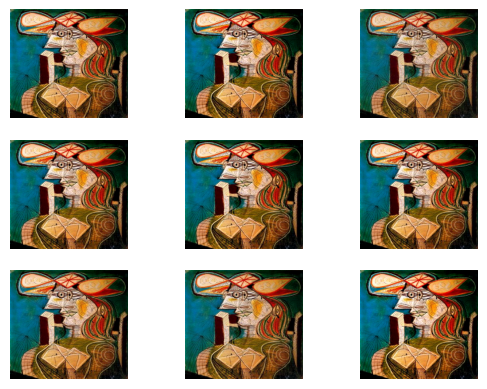

In [24]:
display_augmentation(train, data_augmentation)

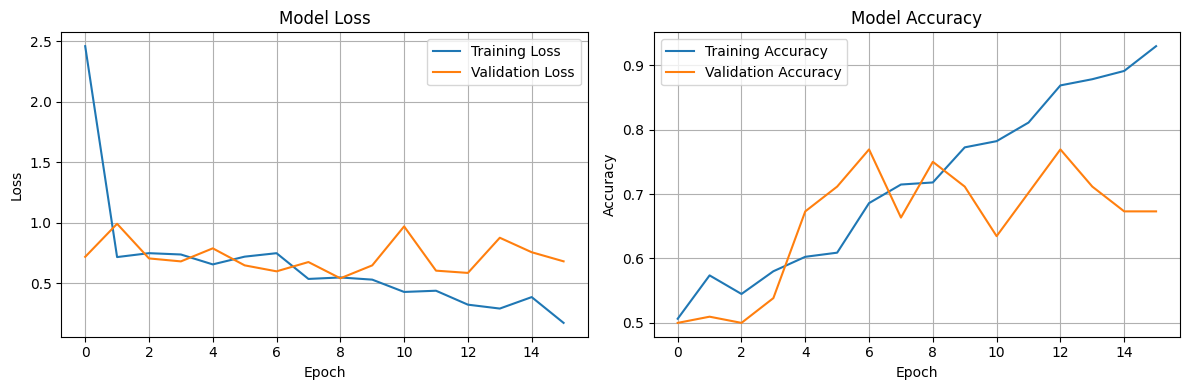

In [25]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [26]:
print_metrics(model, test)

Test Loss: 0.48016637563705444
Test Accuracy: 0.7211538553237915
Test Precision: 0.688524603843689
Test Recall: 0.807692289352417


### Using best 2 data augmentations

In [27]:
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.3),
    layers.RandomTranslation(0.3, 0.3)
])

2025-01-04 15:36:46.394088: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


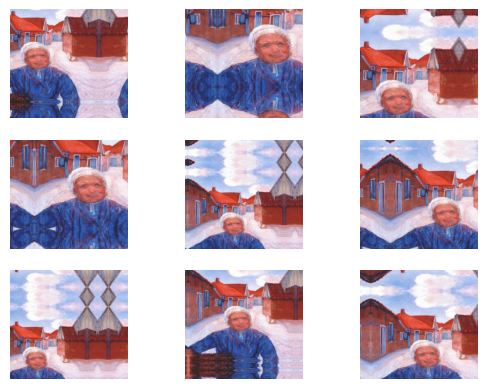

In [28]:
display_augmentation(train, data_augmentation)

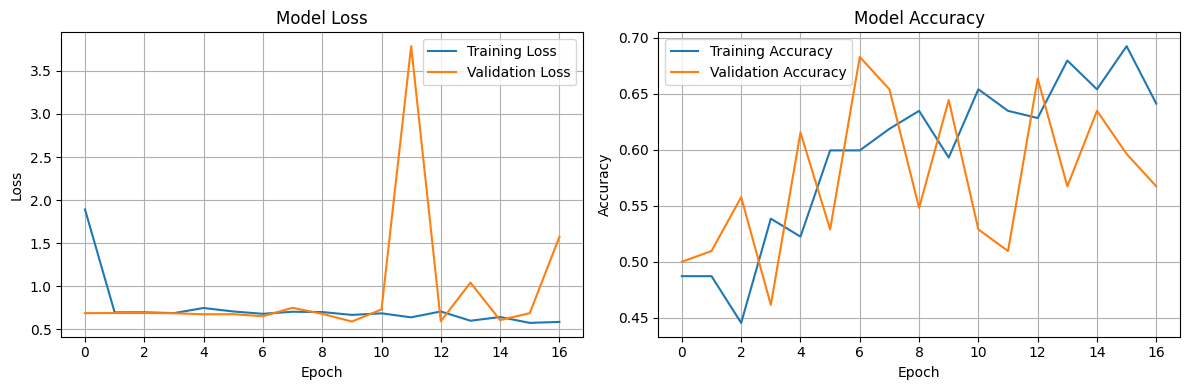

In [29]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [30]:
print_metrics(model, test)

2025-01-04 15:37:45.685319: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Test Loss: 0.5933623909950256
Test Accuracy: 0.6346153616905212
Test Precision: 0.5897436141967773
Test Recall: 0.8846153616905212
